In [15]:
import numpy as np
import math
import matplotlib.pyplot as plt
from node import Node
from node2 import Node2
import pandas as pd
import numpy.linalg as la
import pickle
import time
import random

In [16]:
# with open('test_set.pkl', 'wb') as f:
#         pickle.dump(test_set, f)

with open('test_set.pkl', 'rb') as f: 
    subset = pickle.load(f)


# with open('theta.pkl', 'wb') as f:
#         pickle.dump(theta, f)

with open('theta.pkl', 'rb') as f: 
    theta = pickle.load(f)

# subset = theta.iloc[test_set]

with open('circles_filled_dataset.pkl', 'rb') as f:
    circles = pickle.load(f)

with open('circles_tree.pkl', 'rb') as f:
    c_tree = pickle.load(f)
    
#Load in Pre-buit Tree from MNIST dataset
#better_tree builds in ~2.25 hours
#Split criterion: 100 filters, each node has <100

with open('btree_v2.pkl', 'rb') as f: 
    tree = pickle.load(f)

In [17]:
#Log Likelihood Ratio Functions (natural log)

def llri(obs, exp, q): #score function for poisson (one element)
    return obs*np.log(q) + exp*(1-q)

def llri_pen(obs, exp, q, delta): #penalized score function for poisson (one element)
    return obs*np.log(q) + exp*(1-q) - delta

llr = np.vectorize(llri) #generate unpenalized scores for a given q value

llr_pen = np.vectorize(llri_pen) #genereate penalized scores for a given q value

poissons = np.vectorize(lambda x: np.random.poisson(x))


#DEFINED FUNCTIONS FOR USE IN ALGORITHM:

#BINARY SEARCH FUNCTIONS: ################################################
def q_min(obs, exp):

    minimum = 0.000001
    qmle = obs/exp

    while abs(qmle - minimum) > 0.00000001:
        q_mid = (minimum + qmle)/2

        if llri(obs, exp, q_mid) > 0:
            qmle = qmle - (qmle - minimum)/2
        else:
            minimum = minimum + (qmle - minimum)/2
    return (minimum + qmle)/2

def q_max(obs, exp):

    maximum = 10000000
    qmle = obs/exp

    while abs(maximum - qmle) > 0.000001:
        q_mid = (maximum + qmle)/2

        if llri(obs, exp, q_mid) < 0:
            maximum = maximum - (maximum-qmle)/2
        else:
            qmle = qmle + (maximum-qmle)/2

    return (maximum + qmle)/2

###################################################
def q_min_pen(obs, exp, delta):  #need to fix


    minimum = 0.000001
    qmle = obs/exp

    while abs(qmle - minimum) > 0.00000001:
        q_mid = (minimum + qmle)/2

        if llri_pen(obs, exp, q_mid, delta) > 0:
            qmle = qmle - (qmle - minimum)/2
        else:
            minimum = minimum + (qmle - minimum)/2
    return (minimum + qmle)/2
####################################################

def q_max_pen(obs, exp, delta):

    maximum = 10000000
    qmle = obs/exp

    while abs(maximum - qmle) > 0.000001:
        q_mid = (maximum + qmle)/2

        if llri_pen(obs, exp, q_mid, delta) < 0:
            maximum = maximum - (maximum-qmle)/2
        else:
            qmle = qmle + (maximum-qmle)/2

    return (maximum + qmle)/2
######################################################################################


#FOR FINDING Q-INTERVALS: ###################################################################################
def minmax(obs, exp):
    return (q_min(obs, exp), q_max(obs, exp))

def minmax_pen(obs, exp, delta):
    return [q_min_pen(obs, exp, delta), q_max_pen(obs, exp, delta)]

#Get q intervals
def get_q_values(obs, exp, delta):
    return np.array([q_min(obs, exp), q_min_pen(obs, exp, delta), q_max_pen(obs, exp, delta), q_max(obs, exp)])

# get_all_intervals = np.vectorize(get_q_values)
#############################################################################################################

def relu_scores(scores, delta):
    return min(np.abs(scores), delta)

def ReLU(scores):
    return (scores > 0).view('i1')


def compute_new_subset(scores, filter, delta):
    
    subset = np.zeros(len(filter))
    weights = np.zeros(len(filter))

    for i in range(len(filter)):

        if (scores[i] > delta):
            subset[i] = 1 #always include element in subset
            weights[i] = delta #w_i = delta

        elif (np.abs(scores[i]) <= delta):
            subset[i] = filter[i] #include iff in filter
            weights[i] = np.abs(scores[i]) #w_i = score_i

        else:
            subset[i] = 0 #always exclude from subset
            weights[i] = delta #w_i = delta
            
    return subset, weights

def jaccard(best_s, observed):
    if best_s.shape != observed.shape:
        raise ValueError("Shape mismatch: best_s and observed must have the same shape.")
    intersection = np.logical_and(best_s, observed)
    union = np.logical_or(best_s, observed)
    return intersection.sum() / float(union.sum())

In [18]:
baseline = subset.to_numpy()[2]*10 + 10
observed = poissons(baseline) 
expected = poissons(np.ones((784,))*10) + 0.5
delta = 5

In [19]:
def get_all_intervals(observed, expected, delta):
    for i in range(len(observed)):
        if i == 0:
            q_values = get_q_values(observed[i], expected[i], delta)
        else:
            q_values = np.append(q_values, get_q_values(observed[i], expected[i], delta))
    
    q_values = np.unique(q_values)

    return q_values

In [20]:
q_int = get_all_intervals(observed=observed, expected=expected, delta=delta)
q_int.shape

(956,)

In [7]:
#WORKING ALGORITHM:
###########################################################################

def matched_filter(observed, expected, delta, tree):
    
    for i in range(len(observed)):
        if i == 0:
            q_values = get_q_values(observed[i], expected[i], delta)
        else:
            q_values = np.append(q_values, get_q_values(observed[i], expected[i], delta))     

    q_values = np.unique(q_values)

    delta = 5
    max_score_per_q_range = []
    max_scoring_qmle_per_q_range = []
    max_scoring_S_per_q_range = []
    max_scoring_filter_per_q_range = []

    for i in range(len(q_values) - 1):

        converged = False
        max_score_for_this_q_range = -1E6
        max_scoring_qmle_for_this_q_range = -1E6
        max_scoring_S_for_this_q_range = None
        max_scoring_filter_for_this_q_range = None

        #INITIAL Q VALUE
        qmid = (q_values[i] + q_values[i+1])/2
        print(f"Initial q value (midpoint of q-range): {qmid:{1}.{5}} \n")

        qmle = qmid
        all_unpenalized_element_scores = llr(observed, expected, qmle) 

        while converged == False:

            # STEP 1: DEFINE INITIAL SUBSET AND WEIGHTS FOR FILTER SEARCH
            S_for_filter_search = ReLU(scores=all_unpenalized_element_scores)
            W_for_filter_search = [delta if np.abs(score) > delta else np.abs(score) for score in all_unpenalized_element_scores]

            # STEP 2: TREE TRAVERSAL TO FIND (APPROXIMATELY) OPTIMAL FILTER FOR GIVEN S, W
            filter, _ = tree.traverse(S_for_filter_search, weights=W_for_filter_search) # traverse tree to find best filter 

            # STEP 3: COMPUTE NEW SUBSET FOR GIVEN FILTER
            S, _ = compute_new_subset(scores=all_unpenalized_element_scores, filter=filter, delta=delta)

            # STEP 4: COMPUTE PENALIZED SCORE OF SUBSET S FOR CURRENT qmle
            # (This step is not strictly necessry, and could be removed to save time)
            unpenalized_score = sum(S*all_unpenalized_element_scores)
            pens = np.ones(len(observed))*delta
            total_penalty = sum(pens[filter != S]) 
            penalized_score = unpenalized_score - total_penalty  
            print("Penalized score for current qmle",qmle,":\n",unpenalized_score,"-",total_penalty,"=",penalized_score)

            # STEP 5: RECOMPUTE qmle
            previous_qmle = qmle
            qmle = sum(observed*S)/(sum(expected*S) + 1E-6)

            # STEP 6: COMPUTE PENALIZED SCORE OF SUBSET S FOR NEW qmle
            all_unpenalized_element_scores = llr(observed,expected,qmle)
            unpenalized_score = sum(S*all_unpenalized_element_scores)
            pens = np.ones(len(observed))*delta
            total_penalty = sum(pens[filter != S]) 
            penalized_score = unpenalized_score - total_penalty  
            print("Penalized score for new qmle",qmle,":\n",unpenalized_score,"-",total_penalty,"=",penalized_score)

            if (penalized_score > max_score_for_this_q_range):
                max_score_for_this_q_range = penalized_score
                max_scoring_qmle_for_this_q_range = qmle
                max_scoring_S_for_this_q_range = S
                max_scoring_filter_for_this_q_range = filter
            else: # move to next if score does not increase
                converged = True

            # move to next if qmle converges, or goes outside the current range
            if (np.abs(qmle - previous_qmle) < 0.001) or (qmle < q_values[i]) or (qmle > q_values[i+1]):
                converged = True

            # otherwise, qmle and all_penalized_element_scores are ready for the next loop iteration
            if not converged:
                print("---------------------------------------------------------------------")

        max_score_per_q_range.append(max_score_for_this_q_range)
        max_scoring_qmle_per_q_range.append(max_scoring_qmle_for_this_q_range)
        max_scoring_S_per_q_range.append(max_scoring_S_for_this_q_range)
        max_scoring_filter_per_q_range.append(max_scoring_filter_for_this_q_range)

        print(f"##################################################################### {i}")

    overall_max_position = np.argmax(max_score_per_q_range)
    overall_max_score = max_score_per_q_range[overall_max_position]
    overall_max_scoring_qmle = max_scoring_qmle_per_q_range[overall_max_position]
    overall_max_scoring_S = max_scoring_S_per_q_range[overall_max_position]
    overall_max_scoring_filter = max_scoring_filter_per_q_range[overall_max_position]

    #DISPLAY RESULTS-----------------------------------------           
    plt.subplot(1, 3, 1)
    plt.imshow(overall_max_scoring_filter.to_numpy().reshape(28,28), cmap='gray')
    plt.title("Matched Filter")

    plt.subplot(1, 3, 2)
    plt.imshow(overall_max_scoring_S.reshape(28,28), cmap='gray')
    plt.title("Best Subset")

    plt.subplot(1, 3, 3)
    plt.imshow(observed.reshape(28,28), cmap='gray')
    plt.title("Observed Subset")

    print(f'Max score: {overall_max_score}, qmle: {overall_max_scoring_qmle}')
    print(f'Jaccard coefficient: {jaccard(overall_max_scoring_S, (baseline/10)-1)}')
    print(f'Filter Jaccard coefficient: {jaccard(overall_max_scoring_filter, (baseline/10)-1)}')

Initial q value (midpoint of q-range): 0.014163 

Penalized score for current qmle 0.014162650177846353 :
 0.0 - 170.0 = -170.0
Penalized score for new qmle 0.0 :
 nan - 170.0 = nan
##################################################################### 0
Initial q value (midpoint of q-range): 0.019637 

Penalized score for current qmle 0.019637125210364016 :
 0.0 - 170.0 = -170.0
Penalized score for new qmle 0.0 :
 nan - 170.0 = nan
##################################################################### 1
Initial q value (midpoint of q-range): 0.024289 

Penalized score for current qmle 0.02428866346840496 :
 0.0 - 170.0 = -170.0
Penalized score for new qmle 0.0 :
 nan - 170.0 = nan
##################################################################### 2
Initial q value (midpoint of q-range): 0.029967 

Penalized score for current qmle 0.029966761891202554 :
 0.0 - 170.0 = -170.0
Penalized score for new qmle 0.0 :
 nan - 170.0 = nan
#########################################################

C:\Users\joles\AppData\Local\Temp\ipykernel_17216\4262593293.py:4: RuntimeWarning: divide by zero encountered in log
  return obs*np.log(q) + exp*(1-q)
C:\Users\joles\AppData\Local\Temp\ipykernel_17216\2269534807.py:61: RuntimeWarning: invalid value encountered in multiply
  unpenalized_score = sum(S*all_unpenalized_element_scores)


Penalized score for new qmle 0.0 :
 nan - 170.0 = nan
##################################################################### 4
Initial q value (midpoint of q-range): 0.043522 

Penalized score for current qmle 0.04352211205679343 :
 5.848321744245817 - 175.0 = -169.15167825575418
Penalized score for new qmle 0.22222221234567943 :
 9.979613016118623 - 175.0 = -165.02038698388137
##################################################################### 5
Initial q value (midpoint of q-range): 0.052371 

Penalized score for current qmle 0.05237086479193068 :
 6.574631253630525 - 175.0 = -168.4253687463695
Penalized score for new qmle 0.22222221234567943 :
 9.979613016118623 - 175.0 = -165.02038698388137
##################################################################### 6
Initial q value (midpoint of q-range): 0.059947 

Penalized score for current qmle 0.059946550342155736 :
 7.079692910233939 - 175.0 = -167.92030708976606
Penalized score for new qmle 0.22222221234567943 :
 9.97961301611862

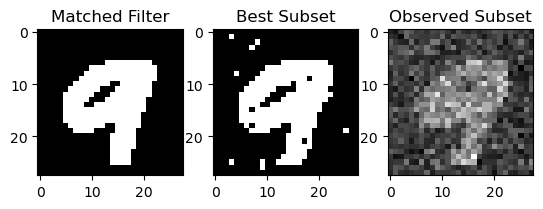

In [9]:
matched_filter(observed=observed, expected=expected, delta=delta, tree=tree)

In [165]:
filters = theta.sample(500).to_numpy()
filters = circles.sample(500).iloc[:, :784].to_numpy()

C:\Users\joles\AppData\Local\Temp\ipykernel_26436\2143006626.py:4: RuntimeWarning: divide by zero encountered in log
  return obs*np.log(q) + exp*(1-q)


Filter = 0
Filter = 1
Filter = 2
Filter = 3
Filter = 4
Filter = 5
Filter = 6
Filter = 7
Filter = 8
Filter = 9
Filter = 10
Filter = 11
Filter = 12
Filter = 13
Filter = 14
Filter = 15
Filter = 16
Filter = 17
Filter = 18
Filter = 19
Filter = 20
Filter = 21
Filter = 22
Filter = 23
Filter = 24
Filter = 25
Filter = 26
Filter = 27
Filter = 28
Filter = 29
Filter = 30
Filter = 31
Filter = 32
Filter = 33
Filter = 34
Filter = 35
Filter = 36
Filter = 37
Filter = 38
Filter = 39
Filter = 40
Filter = 41
Filter = 42
Filter = 43
Filter = 44
Filter = 45
Filter = 46
Filter = 47
Filter = 48
Filter = 49
Filter = 50
Filter = 51
Filter = 52
Filter = 53
Filter = 54
Filter = 55
Filter = 56
Filter = 57
Filter = 58
Filter = 59
Filter = 60
Filter = 61
Filter = 62
Filter = 63
Filter = 64
Filter = 65
Filter = 66
Filter = 67
Filter = 68
Filter = 69
Filter = 70
Filter = 71
Filter = 72
Filter = 73
Filter = 74
Filter = 75
Filter = 76
Filter = 77
Filter = 78
Filter = 79
Filter = 80
Filter = 81
Filter = 82
Filter = 83
Fi

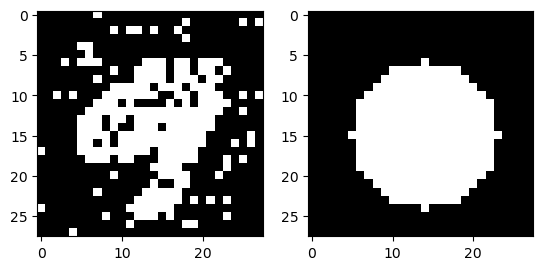

In [166]:
### PFSS WORKING VERSION ###

Fmax = 0
qmle_max = 0
newF_max = 0


for i in range(filters.shape[0]):
    filter = filters[i]

    #compute q intervals:
    # qmin_i is first column, qmax_i is second column
    for k in range(len(observed)):
        if k == 0:
            qs = np.array([minmax_pen(observed[k], expected[k], delta)])
        else:
            qs = np.append(qs, [minmax_pen(observed[k], expected[k], delta)], axis=0)

    q_intervals = np.unique(qs)

    for j in range(len(q_intervals) - 1):
        qmid = (q_intervals[j] + q_intervals[j + 1])/2
        
        # #compute subset 
        initial_subset = ((qmid > qs[:,0]) & (qmid < qs[:,1])*1)    

        qmle = sum(observed[initial_subset == 1])/sum(expected[initial_subset == 1], 0.000001)
        scores = llri(observed[initial_subset == 1], expected[initial_subset == 1], qmle)
        all_scores = llri(observed, expected, qmle)
        bonus = ((initial_subset == 1) & (filter == 1)) * delta
        penalties = ((filter == 1) ^ (initial_subset == 1)) * delta
        new_scores = all_scores + bonus - penalties
        new_subset = ReLU(new_scores)

        F = sum(scores) + sum(bonus) - sum(penalties)
        newF = sum(new_scores)


        if F > Fmax:
            Fmax = F
            qmle_max  = qmle
            best_s = new_subset
            best_f = filter
            index_best = i
            newF_max = newF

    print(f"Filter = {i}")

plt.subplot(1,2,1)
plt.imshow(best_s.reshape(28,28), cmap='gray')

plt.subplot(1,2,2)
plt.imshow(best_f.reshape(28,28), cmap='gray')

print(f"FMAX: {Fmax}\nQMLE: {qmle_max}\n Index_Best = {index_best}")

Initial q value (midpoint of q-range): 0.0022115 

Penalized score for current qmle 0.002211462432494858 :
 1.2419427608784908 - 20.0 = -18.75805723912151
Penalized score for new qmle 0.14814813717421207 :
 7.680914990231118 - 20.0 = -12.319085009768882
##################################################################### 0
Initial q value (midpoint of q-range): 0.0043205 

Penalized score for current qmle 0.004320525859243288 :
 2.5529165859851712 - 20.0 = -17.447083414014827
Penalized score for new qmle 0.14814813717421207 :
 7.680914990231118 - 20.0 = -12.319085009768882
##################################################################### 1
Initial q value (midpoint of q-range): 0.0085542 

Penalized score for current qmle 0.008554229559425088 :
 3.8618590348736923 - 20.0 = -16.138140965126308
Penalized score for new qmle 0.14814813717421207 :
 7.680914990231118 - 20.0 = -12.319085009768882
##################################################################### 2
Initial q value (mid

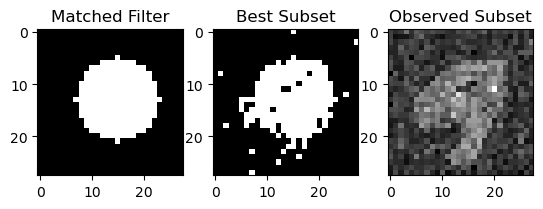

In [172]:
matched_filter(observed=observed, expected=expected, delta=delta, tree = c_tree)